# Gradient Boosting Tree for Airbnb


**Outline**

* [Read Data](#read)
* [Data Transformation](#transform)
* [Model Building](#model) 
    * [Parameter Tuning](#tune)
* [Feature Importance](#feature) 
* [Reference](#refer)

In [34]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import model_selection
from sklearn.ensemble.partial_dependence import plot_partial_dependence

SEED = 12345

## <a id="read">Read Data</a>

In [35]:
def data_reader():
    """
    read data into notebook 
    """
        
    data_dir = os.path.join('.') 

    train_binary_path = os.path.join(data_dir, 'train_session_updated.csv')  
    train_binary = pd.read_csv(train_binary_path) #, index_col = 0
    if 'Unnamed: 0' in train_binary.columns:
        del train_binary['Unnamed: 0']
    drop_feature = ['user_id', 'total_secs_elapsed', 'date_account_created','timestamp_first_active','date_first_booking','country_destination']
    train_binary.drop(drop_feature, axis=1, inplace=True)

    return train_binary

In [36]:
train_binary = data_reader()

In [37]:
train_binary.columns

Index(['ajax_refresh_subtotal', 'dashboard', 'edit', 'header_userpic',
       'personalize', 'similar_listings', 'total_actions', 'obs_count',
       'unique_action', 'unique_device', 'avg_time', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'isNDF'],
      dtype='object')

## <a id="transform">Data Transformation</a>

In [38]:
categorical = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel',
                'affiliate_provider','first_affiliate_tracked','signup_app','first_device_type',
               'first_browser']    

In [39]:
# Convert data type as 'category'
for i in categorical:
    train_binary[i] = train_binary[i].astype('category')

In [40]:
# Create dummy variables
train_binary_dummy = pd.get_dummies(train_binary, columns = categorical)
train_binary_dummy.head()

,ajax_refresh_subtotal,dashboard,edit,header_userpic,personalize,similar_listings,total_actions,obs_count,unique_action,unique_device,...,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_Sogou Explorer,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,2,4,0,2,4,3,15,3.713572,13,2,...,0,1,0,0,0,0,0,0,0,0
1,0,2,0,2,0,0,4,6.672033,25,2,...,0,0,0,0,0,0,0,0,0,0
2,21,3,0,2,26,12,64,6.194405,20,1,...,0,1,0,0,0,0,0,0,0,0
3,12,2,18,2,12,17,63,5.181784,38,2,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,1,4,1,11,3.295837,11,2,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Split data into response and predictors
y = train_binary_dummy['isNDF']
x = train_binary_dummy.drop('isNDF', axis=1)

## <a id="model">Model Building</a>

In [9]:
def fit_gbm(X_train, y_train, param_setting={}, fold=5, seed=SEED):
    """Gradient Boosting Machine for Classification, get the CV AUC"""

    # set seed and default parameter 
    params_default = {'random_state':seed}

    # update the input parameters
    params = dict(params_default)
    params.update(param_setting)
    
    # create model object
    model = GradientBoostingClassifier(**params)
    
    # do kfold cross validation and use auc as metrics
    kfold = model_selection.KFold(n_splits=fold, random_state=seed)    
    results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    print(results.mean())
    
    model.fit(X_train, y_train)
    
    return(model)

In [10]:
gbm_base = fit_gbm(x, y, seed=SEED)

0.775500951569


In [11]:
gbm_base

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=12345, subsample=1.0, verbose=0,
              warm_start=False)

### <a id="tune">Parameter Tuning </a>

**Steps**
1. Pick a small shrinkage number 
    * I originally pick learning_rate=0.001, but it takes a long time to run. Therefore, I only use learning_rate=0.1 for now
2. Pick a small internal splitting nodes (default max_depth=3)
3. Input a large number of trees and get the best number of trees according to CV error (try different n_estimators)
4. Pick a best ntree and use gbm function to get the cv error for multiple times
5. Calculate the mean of cv error to get the final CV AUC

In [12]:
def plot_cv_error(x, y, param_setting, fold):
    """Estimate best n_estimator using cross-validation"""
    
    # set seed and default parameter
    params = dict(param_setting)
    n_estimators = params['n_estimators']

    # fit gbm model
    clf = GradientBoostingClassifier(**params)
    clf.fit(x, y)

    def heldout_score(clf, X_test, y_test):
        """compute deviance scores on ``X_test`` and ``y_test`` """
        score = np.zeros((n_estimators,), dtype=np.float64)
        # staged_decision_function: Compute decision function of X for each iteration.
        # Each n_estimator is an iteration. For example, if our n_estimators=10, then there will be 10 iterations            
        for i, y_pred in enumerate(clf.staged_decision_function(X_test)): 
            
            # the default loss function for GradientBoostingClassifier is deviance. 
            # clf.loss_ calculate the loss score using y and yhat
            score[i] = clf.loss_(y_test, y_pred)
        return score

    def cv_estimate(n_splits=3):
        """compute the cv error for each n_estimator"""
        
        # create a cv fold object
        cv = model_selection.KFold(n_splits=n_splits)
        
        # create a gbm object using the input parameter
        cv_clf = GradientBoostingClassifier(**params)
        val_scores = np.zeros((n_estimators,), dtype=np.float64)
        for train, test in cv.split(x, y):
            cv_clf.fit(x.iloc[train], y[train])
            val_scores += heldout_score(cv_clf, x.iloc[test], y[test])
        val_scores /= n_splits
        return val_scores

    # Get the cv error for each n_estimator
    cv_score = cv_estimate(fold)

    # plot the result    
    x_label = np.arange(n_estimators) + 1
    cv_color = list(map(lambda x: x / 256.0, (253, 192, 134)))
    plt.plot(x_label, cv_score, label='CV loss', color=cv_color)
    plt.legend(loc='upper right')
    plt.ylabel('normalized loss')
    plt.xlabel('number of iterations')
    
    return(cv_score)


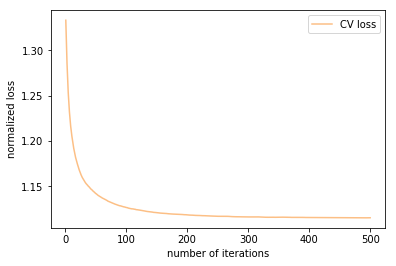

In [13]:
original_params = {
    'n_estimators': 500,
    'learning_rate': 0.1,
    'max_depth': 3,
}

cv_score = plot_cv_error(x, 
                         y, 
                         param_setting=original_params, 
                         fold=5)

In [14]:
# The best number of ntree is 480 with loss 1.115175209690531 (need to figure out what does it mean)
cv_score.argmin()

479

In [15]:
cv_score[cv_score.argmin()]

1.115175209690531

In [16]:
# The CV AUC increase from 0.775500951569 to 0.780516666697 by using the best number of ntree
params = {
    'n_estimators': cv_score.argmin()+1,
    'learning_rate': 0.1,
    'max_depth': 3,
}
gbm_2 = fit_gbm(x, y, param_setting=params)

0.780516666697


In [17]:
gbm_2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=480,
              presort='auto', random_state=12345, subsample=1.0, verbose=0,
              warm_start=False)

In [4]:
def get_cv_score(model, x, y, fold=5, scoring='accuracy', seed=SEED):
    """Get the cv score for a fitted model"""
    
    kfold = model_selection.KFold(n_splits=fold, random_state=seed)
    results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring=scoring)
    print(results.mean())
    
    return results

In [16]:
# get the mean accuracy. The CV misclass rate is 1-0.72=0.28
get_cv_score(gbm_2, x, y, fold=5, scoring='accuracy', seed=SEED)

0.7203184014417143


array([0.72340242, 0.72063903, 0.72210708, 0.71353312, 0.72191035])

In [19]:
gbm_2.fit(x, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=480, presort='auto', random_state=12345,
              subsample=1.0, verbose=0, warm_start=False)

## <a id="feature">Feature Importance</a>

In [25]:
def get_variance_imp_df(model):
    """get the variance importance dataframe for tree based models"""
    
    var_imp = pd.DataFrame(x.columns, model.feature_importances_).reset_index().rename(columns={'index': 'importance',0:'feature'}).sort_values(by=['importance'], ascending=False)
    var_imp = var_imp[['feature','importance']].reset_index(drop=True)
    
    return(var_imp)

In [26]:
gbm_imp = get_variance_imp_df(gbm_2)
gbm_imp.head(15)

,feature,importance
0,avg_time,0.129183
1,age,0.115858
2,obs_count,0.099595
3,unique_action,0.096356
4,ajax_refresh_subtotal,0.057665
5,total_actions,0.051801
6,personalize,0.041459
7,similar_listings,0.036990
8,header_userpic,0.035154
9,edit,0.035152


In [32]:
def viz_importance(var_imp, top):
    y_pos = np.arange(1, top + 1)
    plt.barh(y_pos, list(var_imp['importance'])[0:top][::-1], align = 'center')#, xerr = scores_std[0:top]
    plt.yticks(y_pos, var_imp['feature'][0:top][::-1])
    plt.xlabel('Importance')
    plt.title('Feature Importance Plot')   

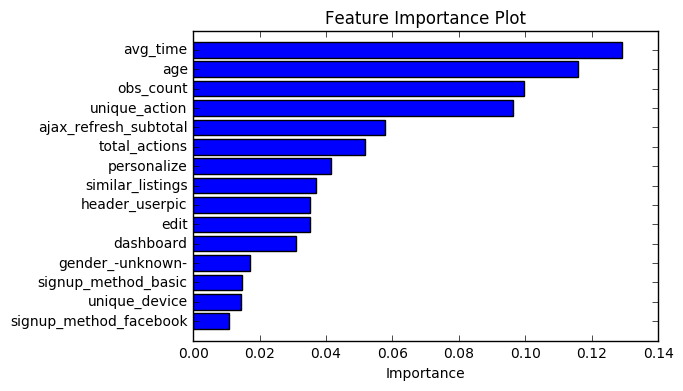

In [33]:
viz_importance(gbm_imp, top=15)

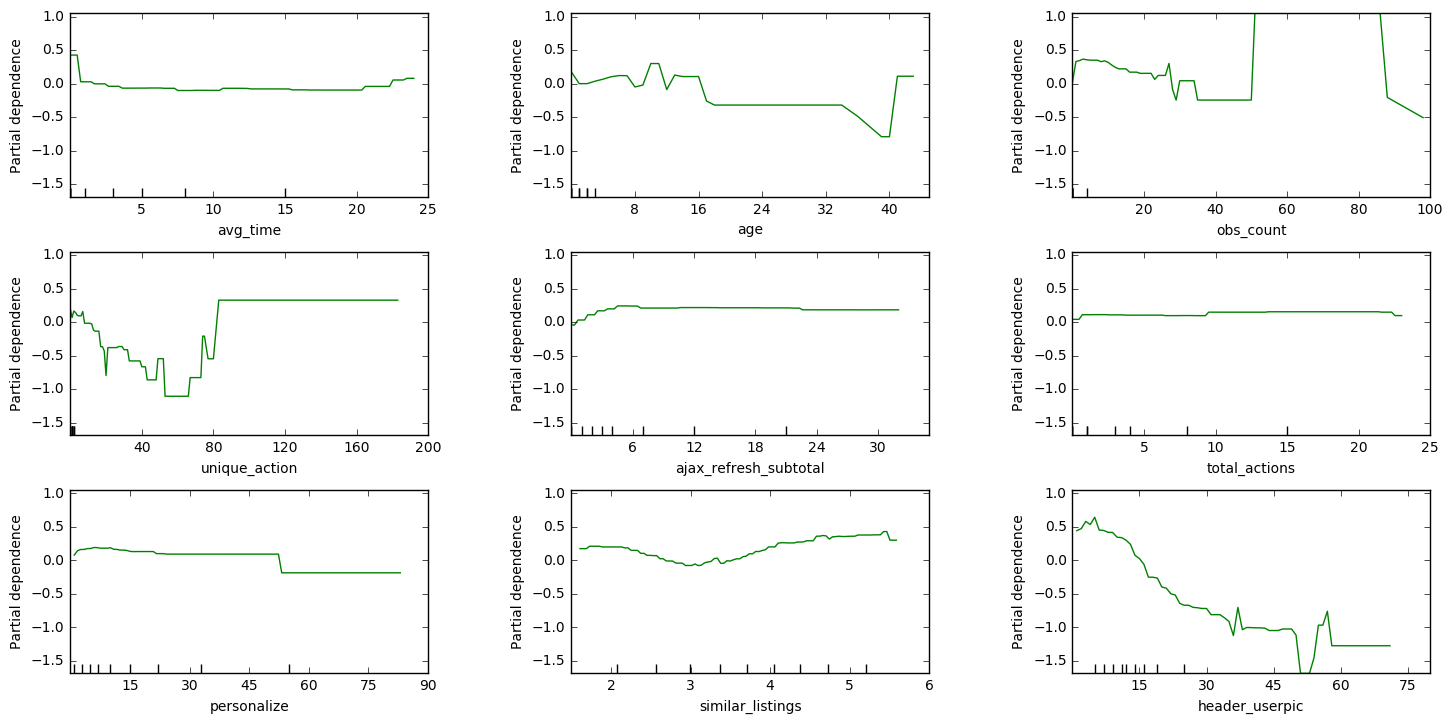

In [31]:
# partial dependency plot for top 9 features
features = list(gbm_imp.feature[0:9])
plot_partial_dependence(gbm_2, x, features, feature_names=features, figsize=(16, 12));

## <a id="refer">Reference</a>

* [Gradient Boosting Out-of-Bag estimates](http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_oob.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-oob-py)
* [Gradient Boosting regularization](http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regularization.html)
* [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
* [sklearn: scoring parameter](http://scikit-learn.org/0.15/modules/model_evaluation.html)
* [Partial Dependency Plot for GradientBoosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.partial_dependence.plot_partial_dependence.html#sklearn.ensemble.partial_dependence.plot_partial_dependence)

---

### Miscellneious (Please Ignore)

**Plot validation set test error**

In [22]:
# original_params = {'n_estimators': 300,
#                        'learning_rate': 0.01,
#                        'max_depth': 3}#'max_leaf_nodes': 4, 'max_depth': None, 'random_state': 2, 'min_samples_split': 5

# params = dict(original_params)

# clf = GradientBoostingClassifier(**params)
# clf.fit(x_train, y_train)

# # compute test set deviance
# test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)
# train_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

# for i, y_pred in enumerate(clf.staged_decision_function(x_test)):
#     # clf.loss_ assumes that y_test[i] in {0, 1}
#     test_deviance[i] = clf.loss_(y_test, y_pred)
# for i, y_pred in enumerate(clf.staged_decision_function(x_train)):
#     # clf.loss_ assumes that y_test[i] in {0, 1}
#     train_deviance[i] = clf.loss_(y_train, y_pred)

# plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
#          '-', color='orange', label='test error')
# plt.plot((np.arange(train_deviance.shape[0]) + 1)[::5], train_deviance[::5],
#          '-', color='blue', label='train error')

# plt.legend(loc='upper left')
# plt.xlabel('Boosting Iterations')
# plt.ylabel('Test Set Deviance')

# plt.show()

In [23]:
def plot_train_test_error_oob(X_train, X_test, y_train, y_test):
    """
    Compare the difference between training and testing error using MSE/R2 by adjusting number of tree built for GBRT.
    Here we use K-fold Cross Validation to obtain the estimate of our test MSE.
    """
    train_mse = list()
#     test_mse = list()
    oob_mse = list()

    seed = 7
    num_trees = 100    
    param_name = 'n_estimators'
    options = np.arange(15, 100)
    
    for n in options:
        # fit random forest using different n_estimator, i.e., the number of trees that we fit each time for bagging.
        rf = RandomForestRegressor(n_estimators=n, oob_score=True, warm_start=True, random_state=seed)
        rf.fit(X_train, y_train)
        
        # get train mse
        train_mse.append(1-rf.score(X_train, y_train))
        
        # get test mse
        test_mse.append(1-rf.score(X_test, y_test))

        # get oob estimates
        oob_mse.append(1-rf.oob_score_.mean())

    mean_mse_scores = [train_mse, test_mse, oob_mse]
    mse_labels = ['train MSE', 'test MSE', 'oob MSE']       
    i_mse_optim = np.argmin(test_mse)
    options_mse_optim = options[i_mse_optim]

    
    # plot with y axis using MSE
    for score, label in zip(mean_mse_scores, mse_labels):
        plt.plot(options, score, label = label)

    plt.vlines(options_mse_optim, plt.ylim()[0], np.min(test_mse), color='k',
           linewidth=3, label='Optimum on test')    
    plt.legend()
    plt.ylabel('OOB Error Rate=1-R^2')
    plt.xlabel(param_name)
    plt.show()
    return(train_mse, test_mse, oob_mse)

In [24]:
param_grid_gbm_2 = {
    'max_depth': [3,  5,  7,  9, 11],                    
    'min_samples_leaf': [1, 3, 5, 7, 9], 
    'max_features': ['auto', 'log2', None, 0.1, 0.3, 0.5, 1],
    'subsample': [0.1, 0.5, 1]
} 
    

In [25]:
param_grid_gbm_1 = {
    'n_estimators': [300], 
    'learning_rate': [0.1]
}

In [26]:
# gbm_2, gs_model = parameter_tuning(gbm, x, y, param_grid_gbm_1)

In [27]:
def parameter_tuning(model, X_train, y_train, param_grid):   
    """
    Tune a tree based model using GridSearch, and return a model object with an updated parameters
    
    Parameters
    ----------
    model: sklearn's ensemble tree model
        the model we want to do the hyperparameter tuning.
    
    X_train: pandas DataFrame
        Preprocessed training data. Note that all the columns should be in numeric format.
    
    y_train: pandas Series
    
    param_grid: dict
        contains all the parameters that we want to tune for the responding model.    
        

    Note
    ----------
    * we use kfold in GridSearchCV in order to make sure the CV Score is consistent with the score 
      that we get from all the other function, including fit_bagging, fit_randomforest and fit_gbm. 
    * We use model_selection.KFold with fixed seed in order to make sure GridSearchCV uses the same seed as model_selection.cross_val_score.
    
    """
    seed=SEED
    
#     if 'n_estimators' in param_grid:
#         model.set_params(warm_start=True) 
    
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    gs_model = GridSearchCV(model, param_grid, cv=kfold, scoring='roc_auc')
    gs_model.fit(X_train, y_train)
    
    # best hyperparameter setting
    print('best parameters:{}'.format(gs_model.best_params_)) 
    print('best score:{}'.format(gs_model.best_score_)) 
    
    # refit model on best parameters
    model.set_params(**gs_model.best_params_)
    model.fit(X_train, y_train)

    return(model, gs_model)